In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

from time import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

from loader import load_data

Autosaving every 15 seconds


Using gpu device 0: GeForce GTX 650 Ti (CNMeM is disabled, CuDNN not available)


In [2]:
train_data, test_data, features, target = load_data('data.csv')

In [3]:
def scale_train_data(data):
    X = data.values.copy()
    X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels).astype(np.int32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print(np.mean(y))
    return X, y, encoder, scaler

def scale_test_data(data, scaler):
    X = data.values.copy()
    X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
    X = scaler.transform(X)
    return X, ids
    
def make_submission(clf, X_test, ids, name):
    predictions = [i[1] for i in clf.predict_proba(X_test)]
    with open(name, 'w') as f:
        f.write('shot_id,shot_made_flag\n')
        for i, prob in zip(ids, predictions):
            f.write(str(i) + ',' + str(prob) + '\n')
    print('Wrote submission to file {}.'.format(name))
    
class EarlyStopping(object):
    def __init__(self, patience=50):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_params = None
        
    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_train = train_history[-1]['train_loss']
        current_epoch = train_history[-1]['epoch']

        if current_train > current_valid:
            return
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_params = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience <= current_epoch:
            if (nn.verbose > 0):
                print('Early stopping')
                print('Best valid loss was {:.6f} at epoch {}'.format(self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_params)
            raise StopIteration()

In [4]:
train_data_parts = [train_data[i::2] for i in range(2)]
X_scaled, y_scaled, encoder, scaler = scale_train_data(train_data)
X_scaled_parts = [X_scaled[i::2] for i in range(2)]
y_scaled_parts = [y_scaled[i::2] for i in range(2)]
X_test_scaled, test_ids = scale_test_data(test_data, scaler)
num_classes = len(encoder.classes_)
num_features = X_scaled.shape[1]
print(num_features)

0.44616103047
104


In [7]:
def process_part(clf, clf_name, part):
    if clf_name.startswith('nn'):
        clf.fit(X_scaled_parts[part], y_scaled_parts[part])
        predicted_other_part = clf.predict_proba(X_scaled_parts[1 - part])[:,1]
    else:
        clf.fit(train_data_parts[part][features].values, train_data_parts[part][target].values)
        predicted_other_part = clf.predict_proba(train_data_parts[1 - part][features].values)[:,1]
    train_data_parts[1 - part]['meta_' + clf_name] = predicted_other_part
        
def process_clf(clf, clf_name):
    for i in [0, 1]:
        process_part(clf, clf_name, i)
    if clf_name.startswith('nn'):
        clf.fit(X_scaled, y_scaled)
        predicted_test = clf.predict_proba(X_test_scaled)[:,1]
    else:
        clf.fit(train_data[features], train_data[target])
        predicted_test = clf.predict_proba(test_data[features])[:,1]
    test_data['meta_' + clf_name] = predicted_test
    
def process_classificators(classificators):
    for clf, name in classificators:
        start = time()
        process_clf(clf, name)
        print('processed ' + name + ' in ' + '{0:.2f}'.format(time() - start))

In [6]:
classificators = []
classificators.append((RandomForestClassifier(n_estimators=300, n_jobs=-1), 'rf'))
classificators.append((ExtraTreesClassifier(n_estimators=300, n_jobs=-1), 'et'))

xgb_params = {
    'base_score': 0.5, 
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 1,
    'n_estimators': 600,
    'nthread': -1,
    'objective': 'binary:logistic',
    'seed': 27,
    'silent': True,
    'subsample': 0.8
}
classificators.append((xgb.XGBClassifier().set_params(**xgb_params), 'xgb'))

early_stopping = EarlyStopping(patience=10)
layers0 = [('input', InputLayer),
           ('dense1', DenseLayer),
           ('dropout1', DropoutLayer),
           ('dense2', DenseLayer),
           ('output', DenseLayer)]

net0 = NeuralNet(layers=layers0,
                 
                 input_shape=(None, num_features),
                 dense1_num_units=200,
                 dropout1_p=0.5,
                 dense2_num_units=200,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 
                 update=nesterov_momentum,
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 on_epoch_finished=[early_stopping],
                 
                 eval_size=0.2,
                 verbose=0,
                 max_epochs=100)
classificators.append((net0, 'nn'))

In [8]:
process_classificators(classificators)

processed rf in 21.59
processed et in 29.28
processed xgb in 105.77
processed nn in 11.37


In [9]:
def lvl2_xgb():
    params = {
        'base_score': 0.5, 
        'colsample_bylevel': 1,
        'colsample_bytree': 0.8,
        'learning_rate': 0.01,
        'max_depth': 8,
        'min_child_weight': 1,
        'n_estimators': 600,
        'nthread': -1,
        'objective': 'binary:logistic',
        'seed': 27,
        'silent': True,
        'subsample': 0.8
    }
    clf = xgb.XGBClassifier()
    clf.set_params(**params)
    clf.fit(train_meta[features].values, train_meta[target].values)
    predicted_test = clf.predict_proba(test_data[features].values)[:,1]
    return predicted_test

def lvl2_nn():
    early_stopping = EarlyStopping(patience=10)
    layers0 = [('input', InputLayer),
               ('dense1', DenseLayer),
               ('dropout1', DropoutLayer),
               ('dense2', DenseLayer),
               ('output', DenseLayer)]

    clf = NeuralNet(layers=layers0,
                        input_shape=(None, num_features),
                        dense1_num_units=200,
                        dropout1_p=0.5,
                        dense2_num_units=200,
                        output_num_units=num_classes,
                        output_nonlinearity=softmax,
                 
                        update=nesterov_momentum,
                        update_learning_rate=0.01,
                        update_momentum=0.9,
                 
                        on_epoch_finished=[early_stopping],
                 
                        eval_size=0.2,
                        verbose=0,
                        max_epochs=100)
    clf.fit(X_scaled, y_scaled)
    predicted_test = clf.predict_proba(X_test_scaled)[:,1]
    return predicted_test

def make_submission(ids, predictions, name):
    with open(name, 'w') as f:
        f.write('shot_id,shot_made_flag\n')
        for i, prob in zip(ids, predictions):
            f.write(str(i) + ',' + str(prob) + '\n')
    print('Wrote submission to file {}.'.format(name))

In [21]:
train_meta = pd.concat([train_data_parts[0], train_data_parts[1]]).sort()
cols = train_meta.columns.tolist()
cols.remove('shot_made_flag')
cols.append('shot_made_flag')
X_scaled, y_scaled, encoder, scaler = scale_train_data(train_meta[cols])
X_test_scaled, test_ids = scale_test_data(test_data, scaler)
num_classes = len(encoder.classes_)
num_features = X_scaled.shape[1]
print(num_features)
features = train_meta.columns.tolist()
features.remove('shot_id')
features.remove(target)

params = {
    'base_score': 0.5, 
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 1,
    'n_estimators': 600,
    'nthread': -1,
    'objective': 'binary:logistic',
    'seed': 27,
    'silent': True,
    'subsample': 0.8
}
clf = xgb.XGBClassifier()
clf.set_params(**params)
clf.fit(train_meta[features], train_meta[target])

0.44616103047
108


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

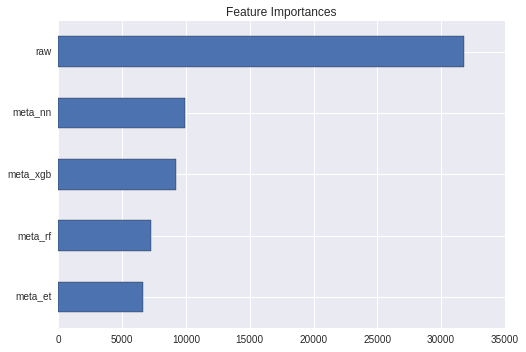

In [28]:
feature_importances = clf.booster().get_fscore()
meta_features = ['meta_rf', 'meta_et', 'meta_xgb', 'meta_nn']
raw = 0
keys = list(feature_importances.keys())
for key in keys:
    if key not in meta_features:
        raw += feature_importances[key]
        feature_importances.pop(key, None)
feature_importances['raw'] = raw
pd.Series(feature_importances).sort_values(ascending=True).plot(kind='barh', title='Feature Importances')

In [13]:
train_meta = pd.concat([train_data_parts[0], train_data_parts[1]]).sort()
cols = train_meta.columns.tolist()
cols.remove('shot_made_flag')
cols.append('shot_made_flag')
X_scaled, y_scaled, encoder, scaler = scale_train_data(train_meta[cols])
X_test_scaled, test_ids = scale_test_data(test_data, scaler)
num_classes = len(encoder.classes_)
num_features = X_scaled.shape[1]
print(num_features)
features = train_meta.columns.tolist()
features.remove('shot_id')
features.remove(target)

pred1 = np.zeros(len(test_data)).astype(np.float32)
pred2 = np.zeros(len(test_data)).astype(np.float32)

runs = 30
for i in range(runs):
    start = time()
    pred1 += lvl2_xgb()
    pred2 += lvl2_nn()
    print(i, time() - start)
    
pred1 = pred1 / runs
pred2 = pred2 / runs
pred = (pred1 + pred2) / 2

make_submission(test_ids, pred1, 'xgb_meta_' + str(runs) + '.csv')
make_submission(test_ids, pred2, 'nn_meta_' + str(runs) + '.csv')
make_submission(test_ids, pred, 'avg_meta_' + str(runs) + '.csv')

0.44616103047
108
0 76.83420944213867
1 76.03630781173706
2 79.07896280288696
3 77.67452669143677
4 78.20903062820435
5 80.09393501281738
6 80.23625206947327
7 81.00965619087219
8 79.85650944709778
9 80.68876099586487
10 83.323477268219
11 81.68512463569641
12 83.49224328994751
13 83.31724643707275
14 83.1957893371582
15 82.25217390060425
16 83.22520089149475
17 80.95010304450989
18 87.20300483703613
19 82.01173567771912
20 94.50144863128662
21 84.81416249275208
22 93.49802827835083
23 85.00609922409058
24 91.58385872840881
25 96.57491755485535
26 105.99097013473511
27 100.3278796672821
28 80.6134877204895
29 107.15479946136475
Wrote submission to file xgb_meta_30.csv.
Wrote submission to file nn_meta_30.csv.
Wrote submission to file avg_meta_30.csv.
